* Materia: Ciencia y Analítica de Datos.
* Nombre de la entrega: Actividad Semanal -- 7 K means
* Fecha: 09/11/2022.
* Roberto Romero Vielma - A00822314
* Profesora titular: María de la Paz Rico Fernández
* Profesor tutor: Roberto Antonio Guevara González.

Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [1]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 7.3 MB/s 
     |████████████████████████████████| 1.0 MB 46.2 MB/s 
     |████████████████████████████████| 1.7 MB 55.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 179 kB 49.8 MB/s 
     |████████████████████████████████| 6.3 MB 30.4 MB/s 
  Created wheel for qeds: filename=qeds-0.7.0-py3-none-any.whl size=27812 sha256=c177b63ec52df2ef639f07edfc80cbd5749047cebbb0301d35115df6d923b8e9
  Stored in directory: /root/.cache/pip/wheels/fc/8c/52/0cc036b9730b75850b9845770780f8d05ed08ff38a67cbaa29
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=abcb8ab896c4a985c115f13dc75beb99fa67e005d2d9f82c5d518845bde471d4
  Stored in directory: /root/.

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas

Importa la base de datos

In [3]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [4]:

df.head()


,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [6]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

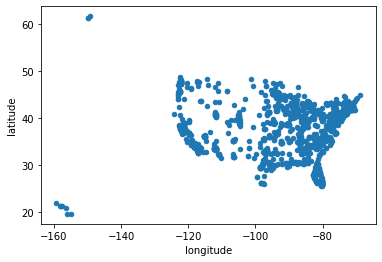

In [7]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [8]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [39]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();
import warnings
warnings.filterwarnings("ignore")

In [10]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [11]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [12]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [13]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

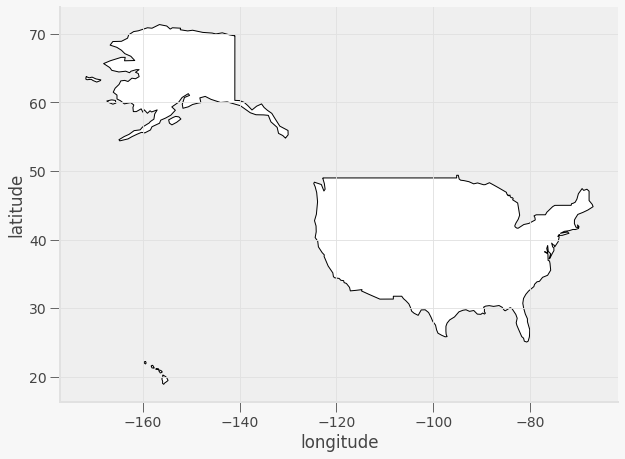

In [14]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

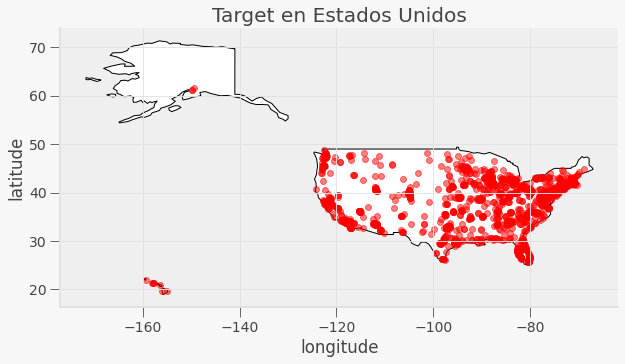

In [15]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

Para encontrar el número óptimo de centros de distribución, importamos el módulo de KMeans dentro de Scikit-learn, junto con el visualizador del método del codo para encontrar la K óptima o número de centros de distribución.

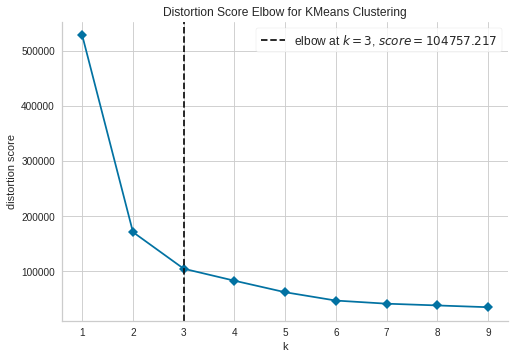

In [16]:
from sklearn.cluster import KMeans #módulo KMeans
from yellowbrick.cluster import KElbowVisualizer #Visualizador del método del codo


model = KMeans(init="random",max_iter=500,random_state=7) #creamos el modelo
plot = KElbowVisualizer(model, k=(1,10),timings=False) # creamos el objeto con el que haremos el plot

plot.fit(latlong) #entrenamos al modelo con nuestros datos
plot.show()        #lo mostramos

Una vez hecho esto, procedemos a utilizar el número óptimo en K para nuestro modelo.

In [17]:
best_center=KMeans(n_clusters=3,init="random",max_iter=500,random_state=7)
best_center.fit(latlong)

KMeans(init='random', max_iter=500, n_clusters=3, random_state=7)

Guardamos los centros (coordenadas) de nuestros centros de distribución

In [18]:
centers=best_center.cluster_centers_

Visualizamos las coordenadas

In [19]:
print(centers)

[[  37.48734203 -118.62447332]
 [  37.789554    -78.56990807]
 [  37.98006261  -93.3271723 ]]


Guardamos las coordenadas dentro de un dataset, la primer columna será la latitud, seguida de la longitud.

In [20]:
locations=pd.DataFrame(centers, columns = ["Latitude","Longitude"])


Guardamos las etiquetas dentro de la variable labels, para posteriormente guardarlas dentro de un dataframe llamado **assigned_distribution_center**

In [21]:
labels=best_center.labels_
assigned_distribution_center=pd.DataFrame(labels,columns=["Distribution center"])

Concatenamos los dataframes latlong y assigned_distribution_center para poder saber el centro de distribución que atiende a cada tienda.

In [22]:
supply_chain=pd.concat([latlong,assigned_distribution_center],axis=1) #axis=1, porque vamos a añadir columnas

Visualizamos el resultado

In [23]:
supply_chain.head()

,latitude,longitude,Distribution center
0,33.224225,-86.804174,2
1,33.334550,-86.989778,2
2,30.602875,-87.895932,2
3,34.560148,-86.971559,2
4,31.266061,-85.446422,1


Ahora graficamos para poder ubicar geográficamente, los centros de ditribución junto con las tiendas a las que abastecerá.

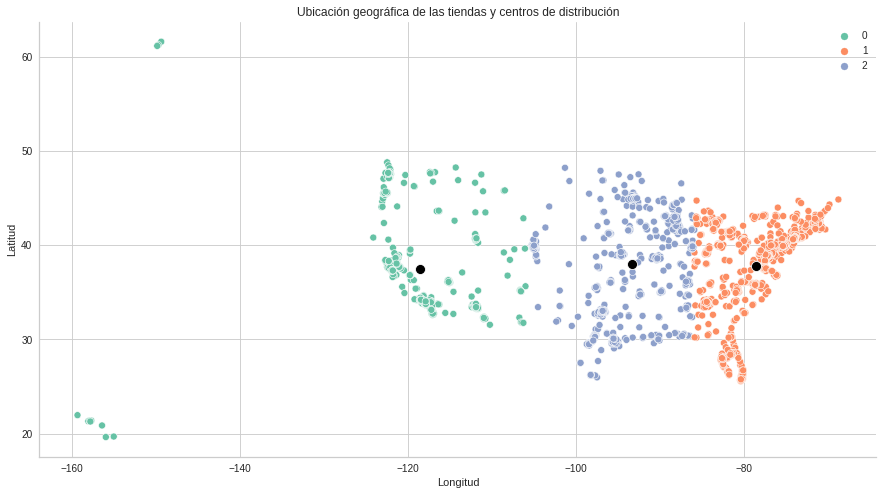

In [24]:
import seaborn as sns
plt.figure(figsize=(15,8))
sns.scatterplot(x="longitude",y="latitude",hue="Distribution center",data=supply_chain,palette="Set2")
sns.scatterplot(x="Longitude",y="Latitude",data=locations,color="black", s=100)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Ubicación geográfica de las tiendas y centros de distribución")
plt.show()

Ahora obtenemos el número de tiendas para cada centro de distribución

In [25]:
n_stores=np.bincount(labels) # se usó np.bincount para contar el número de elementos de cada clase

Guardamos la variable n_stores en un dataframe

In [26]:
n_stores_df=pd.DataFrame(n_stores,columns=["Number of stores per Distribution Center"])

Visualizamos nuestro dataframe

In [27]:
n_stores_df

,Number of stores per Distribution Center
0,385
1,826
2,628


Ahora unimos el dataframe de locations con n_stores para poder visualizar las coordenadas de cada centro de distribución y el número de tiendas a las que abastecerá dentro de un mismo dataframe

In [28]:
locations=pd.concat([locations,n_stores_df],axis=1)

Imprimimos el dataframe

In [29]:
locations

,Latitude,Longitude,Number of stores per Distribution Center
0,37.487342,-118.624473,385
1,37.789554,-78.569908,826
2,37.980063,-93.327172,628


# Encontrar las latitudes y longitudes de los almacenes, además de la ciudad y el número de tiendas a las que va a surtir

Para ello con los datos ya recolectados, se hizo una función para obtener el nombre de la ciudad cercana, a las coordenadas geográficas obtenidas mediante Kmeans.

In [30]:
from geopy.geocoders import Nominatim
from geopy.point import Point

geolocator = Nominatim(user_agent="test")

def reverse_geocoding(lat, lon):
        location = geolocator.reverse(Point(lat, lon))
        return location.raw['display_name']

locations['address'] = np.vectorize(reverse_geocoding)(locations["Latitude"], locations["Longitude"])

locations.head()

,Latitude,Longitude,Number of stores per Distribution Center,address
0,37.487342,-118.624473,385,"Paradise Estates, Mono County, California, Uni..."
1,37.789554,-78.569908,826,"Langhorne Road, Totier Hills, Albemarle County..."
2,37.980063,-93.327172,628,"Hickory County, Missouri, United States"


Tal como se puede observar la primer ubicación se encontrará geográficamente en la posición (37.487342 ,-118.624473), entregará productos a 385 sucursales y estará posicionada cerca de Paradise Estates, Mono County, California, el autor Chopra (2008) menciona que no es necesario, que el centro de distribución se encuentre exactamente en las coordenadas calculadas, la segunda ubicación estará por las coordenadas (37.789554, -78.569908), será el centro de distribución de 826 sucursales y el punto de interés estará ubicado cerca de Langhorne Road, Totier Hills, Albemarle County, Virginia, el último almacén se encontrará por las coordenadas (37.980063, -93.327172), dará servicio a 628 sucursales y estará en un lugar cercano a Hickory County, Missouri. 		

# Encontrar la distancia a la que estará

Ahora utilizando el dataframe **supply_chain** obtenemos la distancia de cada tienda con respecto a su centro de distribución.

Para ello creamos una función que mida la distancia entre dos coordenadas geográficas

In [31]:
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)


Seguido de otra función que separe el dataset de acuerdo al centro de distribución y que calcule la distancia en Km usando la función **harvesine_distance** creada previamente.

In [32]:

def measure_distance(warehouse,start_lat,start_lon): #le pasamos el 
  subset=supply_chain[supply_chain["Distribution center"]==warehouse] #filtramos el almácen que nos interesa
  distances_km = [] #creamos una lista donde llenamos los valores
  for row in subset.itertuples(index=False):
    distances_km.append(
        haversine_distance(start_lat, start_lon, row.latitude, row.longitude) #calculamos la distancia
    )
  subset["distance"]=distances_km #creamos una nueva columna con las distancias obtenidas en el ciclo for
  return subset


Almacenamos el resultado dentro de una variable, posteriormente visualizamos el resultado

In [40]:
warehouse1=measure_distance(0,37.487342,-118.624473)
warehouse1.head()

,latitude,longitude,Distribution center,distance
22,61.577919,-149.402960,0,3415.49
23,61.229952,-149.745967,0,3406.87
24,61.130062,-149.881451,0,3406.16
25,35.052824,-114.591900,0,451.56
26,35.184058,-111.659179,0,674.20


Obtenemos la media de la distancia entre las sucursales y el centro de distribución

In [34]:
warehouse1.distance.mean()

695.3764155844157

La distancia en promedio entre una sucursal y el centro de distribución 1 es de **700 km** aproximadamente. Hacemos lo mismo con los almacenes 2 y 3

In [41]:
warehouse2=measure_distance(1,37.789554,-78.569908)
warehouse2.head()

,latitude,longitude,Distribution center,distance
4,31.266061,-85.446422,1,960.11
11,32.620432,-85.405043,1,845.71
12,33.609201,-85.784654,1,799.90
325,41.340748,-73.079818,1,614.10
326,41.414463,-73.401998,1,598.54


In [36]:
warehouse2.distance.mean()

586.9095641646489

En promedio cada sucursal se encontrará a 590 km del centro de distribución número 2.

In [42]:
warehouse3=measure_distance(2,37.980063,-93.327172)
warehouse3.head()

,latitude,longitude,Distribution center,distance
0,33.224225,-86.804174,2,791.72
1,33.334550,-86.989778,2,770.78
2,30.602875,-87.895932,2,959.67
3,34.560148,-86.971559,2,684.75
5,34.842085,-87.633908,2,617.31


In [38]:
warehouse3.distance.mean()

696.3408598726114

En promedio cada sucursal se encuentra a 700 km del centro de distribución 3


# ¿Cómo elegir el número de almacenes?
Para obtener el número óptimo de almacenes (clusters) se debe usar el método del codo, tal como se puede ver en la gráfica generada anteriormente:

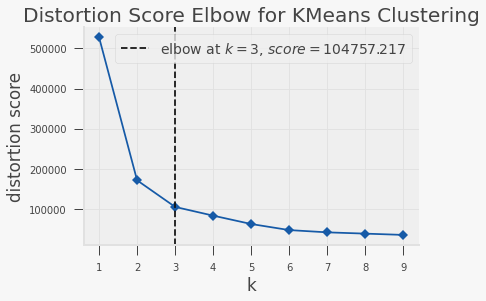

Este método consiste en que se obtiene la función costo de diferentes valores de K enteros, a medida que la K tiene un incremento, el promedio de la distorsión (el promedio de las distancias al cuadrado de los centros de los clusters respectivos) se minimiza, llegando a un punto donde la distorsión casi no disminuye. El punto donde la distorsión tiene el declive más alto se conocerá como codo, este será el punto máximo que deberá tener nuestra K, tal como se puede observar en la siguiente figura, a medida que la K aumenta, la distorsión también disminuye,el punto donde el score de la distorsión tiene el declive más alto se encuentra en ${K = 3}$, por lo que esa ${K}$ será el número de clusters, que nuestro modelo debe utilizar, para tener de forma optimizada la ubicación de nuestros almacenes.

# ¿Qué librerías nos pueden ayudar a graficar este tipo de datos?

* **Geoplot:** Es una librería de alto-nivel para gráficas geoespaciales, es una extensión para CartoPy y Matplotlib, algo que vale la pena mencionar es que es compatible con Matplotlib, además de que permite utilizar geovisualizaciones fáciles de implementar.



Gráfico generado con Geoplot

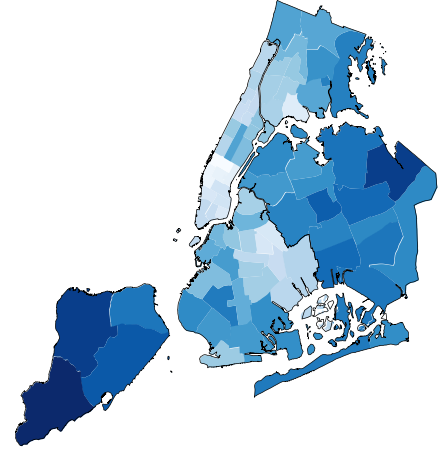

* **Folium:** Es una librería creada en JavaScript mediante Leaflet, por este motivo se puede utilizar esta librería directamente en sitios web, se genera una capa base (por ejemplo un país) seguida de otra capas que se superponen.

Gráfico generado con Folium:

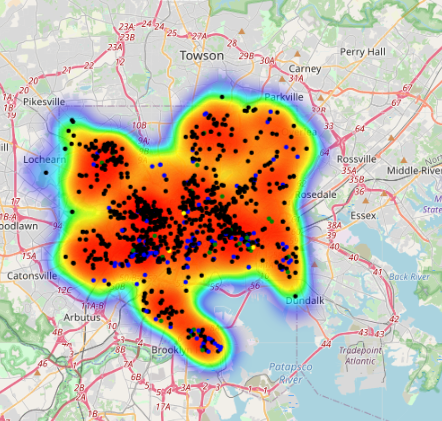

* **Plotly:** Plotly es una librería que permite hacer gráficos interactivos y de muy alta calidad, como los utilizados en artículos de divulgación científica, cuenta con diferentes tipos de gráficos, desde gráficas de barra, de dispersión y los que nos interesan en este caso mapas.

Gráfico generado con Plotly

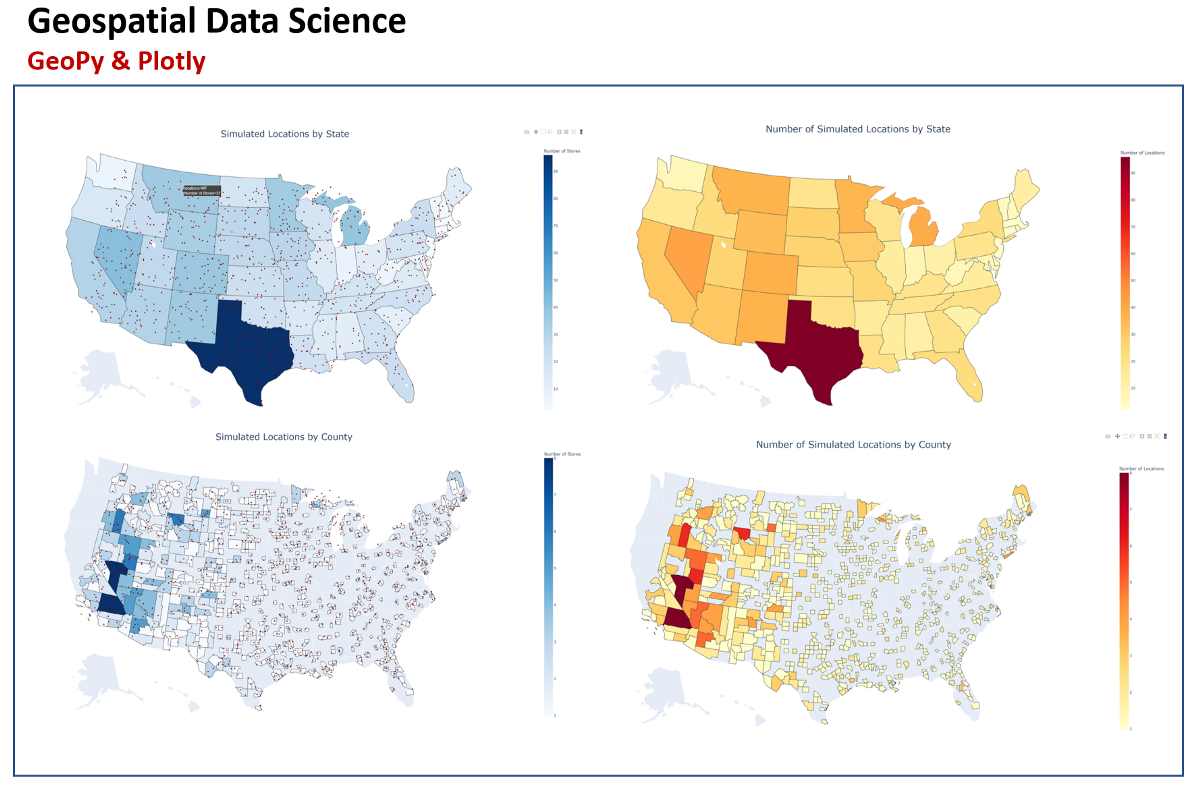

# ¿Consideras importante que se grafique en un mapa?, ¿por qué?

Personalmente considero que si es importante usar librerías que cuenten con gráficas para datos geoespaciales, dado que permiten tener una mejor representación visual de los datos, lo que hace más sencillo entender lo que el gráfico trata de mostrarnos, de no contar con las divisiones territoriales, sería más difícil para el público entender donde ocurre cada instancia, no por nada diferentes herramientas para BI como Power BI y Tableau incluyen los mapas dentro de los tipos de gráficos que se pueden a utilizar, para representar ventas en cierto Estado, cantidad de contagios de Covid-19 por zona, entre otros, por todo lo anteriormente mencionado, considero importante el uso de mapas dentro de la visualización de datos geoespaciales.

# Conclusiones
Del método del codo se obtuvo que la cantidad de clusters (almacenes) necesarios es de 3, mismos que se ubicarán en 3 estados: California, Virginia y Missouri, las coordenadas obtenidas no necesariamente serán las más adecuadas para construir los almacenes, estos edificios pueden encontrarse en una posición geográfica, cercana al punto de referencia obtenido con K-means, los 3 puntos obtenidos nos servirán como referencia para poder construir los edificios, el almacén de Calfornia proveerá de productos a 385 sucursales, mientras que el de Virginia dará servicio a 826 y por último Missouri atenderá a 628 sucursales. En promedio la distancia que recorrerán los camiones entre el almacén y la sucursal estará en el rango de 600 a 700 km.

# Referencias bibliográficas
Chopra, S. (2008). Administración de la cadena de suministro. Pearson education.

Post, F. H., Nielson, G., & Bonneau, G. P. (Eds.). (2002). Data visualization: The state of the art.